In [1]:
import os
import matplotlib.pyplot as plt


In [7]:
import os
import json
import pandas as pd

# read file
data_dir = "../bva-citation-prediction/data/preprocessed-cached/preprocessed-cached-v4/"
# get list of filepaths in data_dir
filepaths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

# read filepaths into dataframe
dicts = []
for filepath in (filepaths):
    with open(filepath) as f:
        data = json.load(f)
        dicts.append(data)

df = pd.DataFrame.from_dict(dicts)


In [8]:
# return all occurences of str in string
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

df['num_citations'] = df['citation_vocab'].apply(lambda x: len(x))

## stats on number of citations

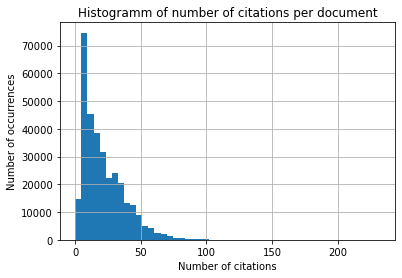

In [9]:
# plot histogramm
df['num_citations'].hist(bins=50)
plt.title('Histogramm of number of citations per document')
plt.ylabel('Number of occurrences')
plt.xlabel('Number of citations')
plt.show()

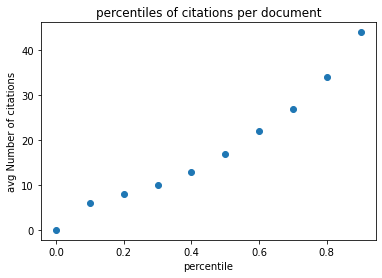

In [10]:
# percentiles
percentiles = [i/10 for i in range(0, 10)]
citations_per_percentile = df['num_citations'].quantile(percentiles)
plt.title("percentiles of citations per document")
plt.ylabel("avg Number of citations")
plt.xlabel("percentile")
plt.scatter(percentiles, citations_per_percentile)
plt.show()

Text(16, 0.5438149727574628, '54% of documents have >15 citations')

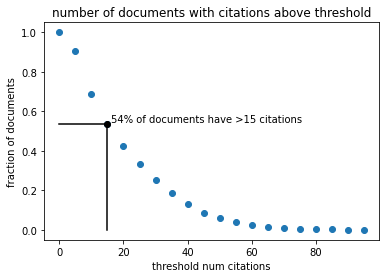

In [11]:
# percentages of documents with more than x citations
thresholds = [i*5 for i in range(20)]
occurences = []
for threshold in thresholds:
    # count occurences of num_citations above threshold
    occurences.append(df["num_citations"][df['num_citations'] > threshold].count())
# normalize by total number of documents
occurences = [i/len(df) for i in occurences]
plt.title("number of documents with citations above threshold")
plt.ylabel("fraction of documents")
plt.xlabel("threshold num citations")
plt.scatter(thresholds, occurences)

# highlight point (20, 0.4)
plt.scatter(thresholds[3], occurences[3], color='black')
# draw line at thresholds[3] and occurences[3]
plt.plot([thresholds[3], thresholds[3]], [0, occurences[3]], color='black')
# draw horiton line
plt.plot([0, thresholds[3]], [occurences[3], occurences[3]], color='black')
# annoate 3
plt.annotate("54% of documents have >15 citations", xy=(thresholds[3], occurences[3]), xytext=(thresholds[3]+1, occurences[3]+0.01), color='black')

In [13]:
# average number of citations per document
print("average number of citations per document:", df['num_citations'].mean())
# total number of citations
print("total number of citations:", df['num_citations'].sum())
print("num docuemnts", len(df))

average number of citations per document: 21.584470366224803
total number of citations: 7000038
num docuemnts 324309


: 

## types of citations

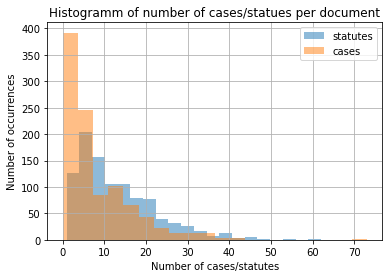

In [227]:
is_statute = lambda citation_variants: any("§" in variant for variant in citation_variants)
count_statutes = lambda citations: sum(is_statute(citation) for citation in citations)
count_cases = lambda citations: sum(not is_statute(citation) for citation in citations)

df['num_statues'] = df['citation_vocab'].apply(count_statutes)
df['count_cases'] = df['citation_vocab'].apply(count_cases)
df['num_statues'].hist(bins=20, alpha=0.5, label='statutes')
df['count_cases'].hist(bins=20, alpha=0.5, label='cases')
# title and axes
plt.title('Histogramm of number of cases/statues per document')
plt.ylabel('Number of occurrences')
plt.xlabel('Number of cases/statutes')
plt.legend()
plt.show()

## most common citations

In [228]:
# to simplify: use only longest string of citation variants
def get_longest(citations):
    longest_variants = []
    for citation_variants in citations:
        longest = max(citation_variants, key=len)
        longest_variants.append(longest)
    return longest_variants

df['longest_citations'] = df['citation_vocab'].apply(get_longest)
# longest citations is a list of citations instead of a list of a list of citations

In [229]:
from collections import Counter
# count duplicates in df['longest_citations']
all_citations = df['longest_citations'].to_list()
# flatten all_citations
def flatten(t):
    return [item for sublist in t for item in sublist]

flattened = flatten(all_citations)
counted = Counter(flattened)


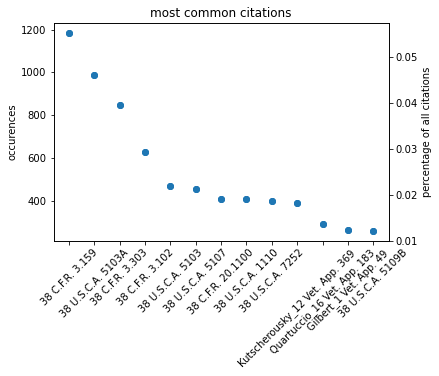

In [230]:
# select the 13 most common items
most_common = counted.most_common(13)
# convert list of tuples to two lists
most_common_citations, most_common_counts = zip(*most_common)
# normalize most_common_counts by total number of citations
# make the x axis labels diagonal
plt.xticks(rotation=45)

plt.scatter(most_common_citations, most_common_counts)
# show second y axis
plt.ylabel("occurences")

# show second y axis for normalized values
plt.twinx()
most_common_counts_normalized = [(i/len(flattened)) for i in most_common_counts]
plt.scatter(most_common_citations, most_common_counts_normalized)
plt.ylabel("percentage of all citations")

plt.title('most common citations')
plt.show()

In [231]:
# mean of counted values
print(sum(list(counted.values()))/len(list(counted.values())))

13.441028858218319


## Document texts
### average number of words

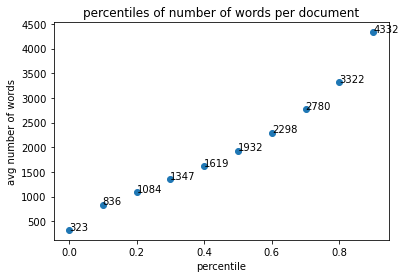

In [232]:
count_words = lambda x: len(x.split(" "))
df['num_words'] = df['txt'].apply(count_words)

# plot num_word percentiles
bins = 10
percentiles = [i/bins for i in range(0, bins)]
num_words_per_percentile = df['num_words'].quantile(percentiles)
plt.title("percentiles of number of words per document")
plt.ylabel("avg number of words")
plt.xlabel("percentile")

plt.scatter(percentiles, num_words_per_percentile)
# annotate the plot
for i in range(len(percentiles)):
    num = num_words_per_percentile[percentiles[i]]
    rounded = int(num)
    plt.annotate(rounded, (percentiles[i], num))
plt.show()

In [233]:
# average number of words
print(df['num_words'].mean())

2306.677


### citations per sentence: 
with an avg of ~20 citations and 2300 words per doc, and assuming 15 words per sentence there is a citation every ~7 sentences

### citation positions 
(relative to document length)
only for documents between length 800 and 1000

Text(0.5, 0, 'Normalized indices')

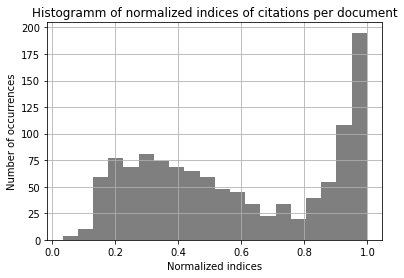

In [238]:
def normalize_nested_indices(x, txt):
    length = len(txt)
    tmp = find_all(txt, "@cit@")
    # find all indices of substring str in txt
    tmp = [el /length for el in tmp]
    return tmp

# drop docuements with num_words > 1000
df_short = df[df['num_words'] < 1500]
df_short = df_short[df_short['num_words'] > 1200]

df_short['normalized_indices'] = df_short.apply(lambda x: normalize_nested_indices(x['citation_indices'], x['txt']), axis=1)

df_short['normalized_indices'].hist(bins=20)
flattened = flatten(df_short['normalized_indices'].to_list())
plt.hist(flattened, bins=20)
plt.title('Histogramm of normalized indices of citations per document')
plt.ylabel('Number of occurrences')
plt.xlabel('Normalized indices')
